In [1]:
import sys
import os

# Adjust the path to point to your project root.
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# from modules import Bloch, Model, K_mesh, Wannier
# from modules.bloch import finite_diff_coeffs, levi_civita
# from pythtb import Bloch, TBModel, KMesh, Wannier
# from pythtb.utils import finite_diff_coeffs, levi_civita
from modules.axion import get_axion_angle
from calculations.models import fu_kane_mele
# from pythtb import *
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from itertools import product

%load_ext line_profiler
%timeit

In [3]:
########## Model #############

# Reference Model
t = 1     # spin-independent first-neighbor hop
soc = 1/4   # spin-dependent second-neighbor hop
m = 1/2     # magnetic field magnitude
beta = np.pi/4  # Adiabatic parameter
fkm_model = fu_kane_mele(t, soc, m, beta)

# Model generator for a set of fixed parameters
fixed_params = {"t": 1.0, "soc": 1/4, "m": 1/2}
model_gen = partial(fu_kane_mele, **fixed_params)

### Adiabatic parameters
# k space
nks = 40, 40, 40
k_flat = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=False) for nk in nks])))

# lambda space
n_beta = 120
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic
lambda_vals = {"beta": betas}

########### Useful model information ###########
recip_lat_vecs = fkm_model.get_recip_lat()  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.nspin   # Number of spins
n_orb = fkm_model.norb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_spin}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))

Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (40, 40, 40, 120)
Total number of parameter points: 7680000


In [4]:
thetas_c2 = np.load('data/thetas_kubo_40_40_40_120.npy')

In [5]:
betas_3form = np.linspace(0, 2*np.pi, 21, endpoint=True)
nks_beta_plot = 100, 100, 100
thetas_3form_curv = np.zeros((betas_3form.shape[0]))
thetas_3form_conn = np.zeros((betas_3form.shape[0]))

for idx, beta in enumerate(betas_3form):
    model = fu_kane_mele(t, soc, m, beta)

    # trial wavefunctions of form (orbital, spin, amp)
    if beta == np.pi:
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [ [(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    theta, theta2 = get_axion_angle(model, tf_list, both=True, order_fd=21, *nks_beta_plot)
    thetas_3form_curv[idx] = theta
    thetas_3form_conn[idx] = theta2

    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}")

2025-06-05 15:37:16.721177: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-05 15:37:16.721212: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-05 15:37:16.721218: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-05 15:37:16.721231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-05 15:37:16.721240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


idx: 0, beta: 0.0, theta: 3.343757053675132e-10
idx: 1, beta: 0.3141592653589793, theta: 0.24201723340268458
idx: 2, beta: 0.6283185307179586, theta: 0.3966096220578609
idx: 3, beta: 0.9424777960769379, theta: 0.4873437755370789
idx: 4, beta: 1.2566370614359172, theta: 0.563328682341349
idx: 5, beta: 1.5707963267948966, theta: 0.6628195805782189
idx: 6, beta: 1.8849555921538759, theta: 0.82200647402494
idx: 7, beta: 2.199114857512855, theta: 1.0881738585980207
idx: 8, beta: 2.5132741228718345, theta: 1.5284656635904486
idx: 9, beta: 2.827433388230814, theta: 2.217142471364299
idx: 10, beta: 3.141592653589793, theta: 3.1415928442289722
idx: 11, beta: 3.4557519189487724, theta: -2.217143107984072
idx: 12, beta: 3.7699111843077517, theta: -1.5284656635904486
idx: 13, beta: 4.084070449666731, theta: -1.088174017752964
idx: 14, beta: 4.39822971502571, theta: -0.8220062352925253
idx: 15, beta: 4.71238898038469, theta: -0.6628194612120116
idx: 16, beta: 5.026548245743669, theta: -0.5633289210

Text(0.5, 1.0, '$N_k = $(100, 100, 100)')

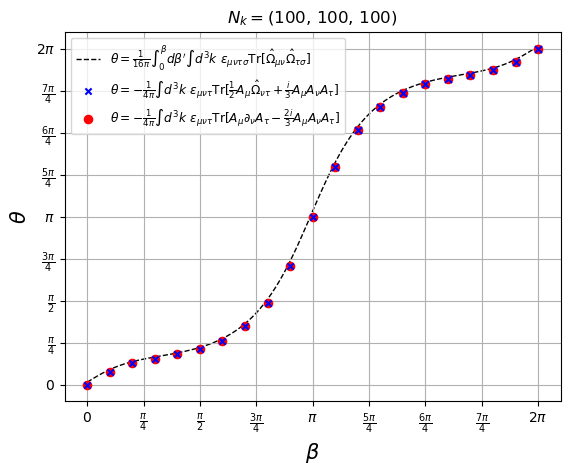

In [6]:
fig, ax = plt.subplots()

ax.plot(betas, thetas_c2.real, lw=1, zorder=1, c='k', ls='--',
        label=r"$\theta = \frac{1}{16\pi} \int_0^{\beta}d\beta' \int d^3k\ \epsilon_{\mu\nu\tau\sigma}  \text{Tr}[\hat{\Omega}_{\mu\nu} \hat{\Omega}_{\tau\sigma}]$")  
# ax.scatter(betas, thetas_c2.real, s=4, zorder=2, c='r', 
#            label=r"$\theta = \frac{1}{16\pi} \int_0^{\beta}d\beta' \int d^3k\ \epsilon_{\mu\nu\tau\sigma}  \text{Tr}[\hat{\Omega}_{\mu\nu} \hat{\Omega}_{\tau\sigma}]$")

ax.scatter(betas_3form[:11], thetas_3form_curv[:11], s=20, c='b', zorder=3, marker='x',
           label=r'$\theta = -\frac{1}{4\pi} \int d^3k\ \epsilon_{\mu\nu\tau} \text{Tr} [\frac{1}{2}A_{\mu}\hat{\Omega}_{\nu\tau} + \frac{i}{3} A_\mu A_\nu A_\tau]$')
ax.scatter(betas_3form[11:], thetas_3form_curv[11:]+2*np.pi, s=25, c='b', zorder=3, marker='x')

ax.scatter(betas_3form[:11], thetas_3form_conn[:11], s=35, c='r', zorder=2, marker='o', 
           label=r'$\theta = -\frac{1}{4\pi} \int d^3k\ \epsilon_{\mu\nu\tau} \text{Tr} [ A_{\mu}\partial_{\nu} A_{\tau} -\frac{2i}{3} A_\mu A_\nu A_\tau]$'
           )
ax.scatter(betas_3form[11:], thetas_3form_conn[11:]+2*np.pi, s=35, c='r', zorder=2, marker='o')

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# ax.set_ylim(0, 2*np.pi+0.1)
# ax.set_xlim(0, 2*np.pi+0.1) 
# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend(loc='upper left', prop={'size': 8.8})
ax.set_title(fr"$N_k = ${nks_beta_plot}")

In [8]:
nkxs = np.array([10, 20, 30, 40, 50, 75, 100, 125 ])
delta_theta_curv = np.zeros(nkxs.shape)
thetas_beta_pi_curv = np.zeros(nkxs.shape)
delta_theta_conn = np.zeros(nkxs.shape)
thetas_beta_pi_conn = np.zeros(nkxs.shape)

beta = np.pi

for idx, nkx in enumerate(nkxs):
    print(nkx)
    nks = nkx, nkx, nkx

    model = fu_kane_mele(t, soc, m, beta)

    # trial wavefunctions of form (orbital, spin, amp)
    tf_list = [ 
        [(0, 0, -1), (0, 1, 1)], 
        [(1, 0, 1), (1, 1, 1)]
        ]
    
    theta_curv, theta_conn = get_axion_angle(model, tf_list, both=True, order_fd=21, *nks)

    delta_theta_curv[idx] = abs(theta_curv.real) - np.pi
    thetas_beta_pi_curv[idx] = theta_curv.real

    delta_theta_conn[idx] = abs(theta_conn.real) - np.pi
    thetas_beta_pi_conn[idx] = theta_conn.real

10
20
30
40
50
75
100
125


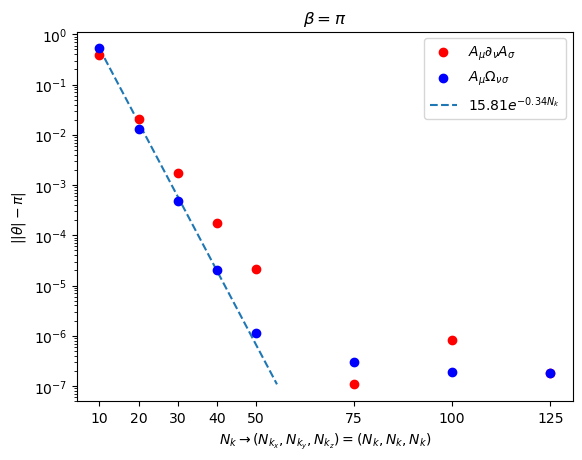

In [9]:
fig, ax = plt.subplots()

ax.scatter(nkxs[:], abs(delta_theta_conn[:]), c='r', label=r'$A_{\mu} \partial_{\nu} A_{\sigma}$')
ax.scatter(nkxs[:], abs(delta_theta_curv[:]), c='b', label=r'$A_{\mu}\Omega_{\nu\sigma}$')

# error
N = np.linspace(nkxs[0], nkxs[-1], 100)
a = 0.34
C = abs(delta_theta_curv[0])*np.exp(a*N[0])
fit = C*np.exp(-a * N)
ax.plot(N[:40], fit[:40], ls='--', label=rf'${C:.2f}e^{{-{a} N_k}}$', zorder=0)

ax.set_xlabel(r'$N_k \rightarrow (N_{k_x}, N_{k_y}, N_{k_z}) = (N_{k}, N_{k}, N_{k})$')
ax.set_ylabel(r'$| |\theta| - \pi |$')
ax.set_title(r"$\beta = \pi$")
ax.set_xticks(nkxs)

plt.yscale('log') 
plt.legend()